In [1]:
## Layoff Analysis

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/layoffs-2022/layoffs.csv


In [4]:
df = pd.read_csv('/kaggle/input/layoffs-2022/layoffs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2545 entries, 0 to 2544
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2545 non-null   object 
 1   location             2545 non-null   object 
 2   industry             2543 non-null   object 
 3   total_laid_off       1746 non-null   float64
 4   percentage_laid_off  1694 non-null   float64
 5   date                 2543 non-null   object 
 6   stage                2539 non-null   object 
 7   country              2545 non-null   object 
 8   funds_raised         2297 non-null   float64
dtypes: float64(3), object(6)
memory usage: 179.1+ KB


In [5]:
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,N26,Berlin,Finance,71.0,0.04,2023-04-28,Series E,United States,1700.0
1,Providoor,Melbourne,Food,NaN,1.00,2023-04-28,Unknown,Australia,NaN
2,Dropbox,SF Bay Area,Other,500.0,0.16,2023-04-27,Post-IPO,United States,1700.0
3,Vroom,New York City,Transportation,120.0,0.11,2023-04-27,Post-IPO,United States,1300.0
4,Greenhouse,New York City,Recruiting,100.0,0.12,2023-04-27,Private Equity,United States,110.0


In [6]:
df.describe() # numeric values in reasonable range

,total_laid_off,percentage_laid_off,funds_raised
count,1746.000000,1694.000000,2297.000000
mean,256.022337,0.260577,814.143794
std,841.557354,0.258415,5448.104463
min,3.000000,0.000000,0.000000
25%,38.000000,0.100000,50.000000
50%,80.000000,0.170000,156.000000
75%,180.000000,0.300000,442.000000
max,12000.000000,1.000000,121900.000000


In [7]:
df.country.value_counts()[:10] # check top 10 countries which the layoffs companies in

United States     1649
India              169
Canada             108
United Kingdom      80
Brazil              76
Germany             72
Australia           63
Israel              56
Singapore           35
Indonesia           26
Name: country, dtype: int64

In [8]:
# keep only companies in US
df = df[df.country == 'United States']
df.shape

(1649, 9)

In [9]:
# check NaN values
df.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off         551
percentage_laid_off    552
date                     1
stage                    4
country                  0
funds_raised           136
dtype: int64

In [10]:
# drop rows missing industry and stage data
df = df[df.industry.notna() & df.stage.notna()]
df.shape

(1644, 9)

### 1. Which industries are the hardest hit by layoffs?

In [11]:
df.industry.nunique() # total number of industries

29

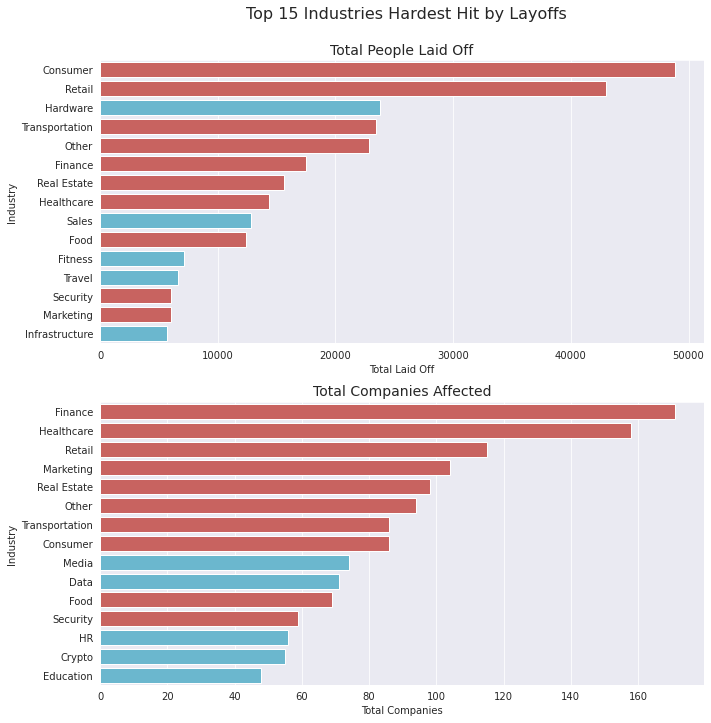

In [12]:
# Visualize top industries

# Top 15 indusries by total layoffs
indsSum = df[['industry', 'total_laid_off']] \
            .groupby('industry', as_index=False).sum() \
            .sort_values(by='total_laid_off', ascending=False)

# Top 15 indusries by total layoff companies
indsCount = df[['industry', 'company']] \
            .groupby('industry', as_index=False).count() \
            .sort_values(by='company', ascending=False)

# Industries in both top ranks
inds = [i for i in indsSum.industry[:15] if i in indsCount.industry[:15].tolist()]

# Create a custom palette to highlight the overlapping industries
palette = ['#d9534f' if industry in inds else '#5bc0de' for industry in indsSum.industry[:15]]

# Create a figure and set the size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
fig.suptitle('Top 15 Industries Hardest Hit by Layoffs', fontsize=16, x=0.57, y=1)

# First subplot (top)
sns.barplot(ax=axes[0], data=indsSum.iloc[:15], x='total_laid_off', y='industry', palette=palette)
axes[0].set_title('Total People Laid Off', fontsize=14)
axes[0].set_xlabel('Total Laid Off')
axes[0].set_ylabel('Industry')

# Update the palette for the second plot
palette = ['#d9534f' if industry in inds else '#5bc0de' for industry in indsCount.industry[:15]]

# Second subplot (bottom)
sns.barplot(ax=axes[1], data=indsCount.iloc[:15], x='company', y='industry', palette=palette)
axes[1].set_title('Total Companies Affected', fontsize=14)
axes[1].set_xlabel('Total Companies')
axes[1].set_ylabel('Industry')

# Adjust the layout and display the combined plots
plt.tight_layout()
plt.show()

In [13]:
inds

['Consumer',
 'Retail',
 'Transportation',
 'Other',
 'Finance',
 'Real Estate',
 'Healthcare',
 'Food',
 'Security',
 'Marketing']

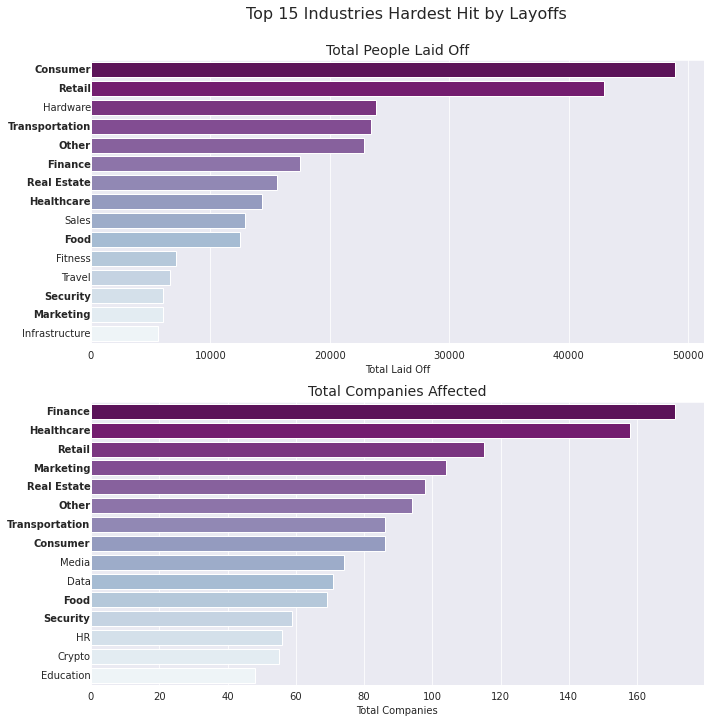

In [14]:
# Verision 2

# Create a figure and set the size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
fig.suptitle('Top 15 Industries Hardest Hit by Layoffs', fontsize=16, x=0.57, y=1)

# First subplot (top)
barplot_1 = sns.barplot(ax=axes[0], data=indsSum.iloc[:15], x='total_laid_off', y='industry', palette='BuPu_r')
axes[0].set_title('Total People Laid Off', fontsize=14)
axes[0].set_xlabel('Total Laid Off')
axes[0].set_ylabel('')

# Bold overlapping industries in y-labels for the first subplot
for i, industry in enumerate(indsSum.industry[:15]):
    if industry in inds:
        axes[0].text(-0.15, i, industry, weight='bold', ha='right', va='center')
    else:
        axes[0].text(-0.15, i, industry, ha='right', va='center')

# Second subplot (bottom)
barplot_2 = sns.barplot(ax=axes[1], data=indsCount.iloc[:15], x='company', y='industry', palette='BuPu_r')
axes[1].set_title('Total Companies Affected', fontsize=14)
axes[1].set_xlabel('Total Companies')
axes[1].set_ylabel('')

# Bold overlapping industries in y-labels for the second subplot
for i, industry in enumerate(indsCount.industry[:15]):
    if industry in inds:
        axes[1].text(-0.15, i, industry, weight='bold', ha='right', va='center')
    else:
        axes[1].text(-0.15, i, industry, ha='right', va='center')

# Remove original y-labels
barplot_1.set(yticklabels=[])
barplot_2.set(yticklabels=[])

# Adjust the layout and display the combined plots
plt.tight_layout()
plt.show()

In [15]:
df["percentage_laid_off"].describe()

count    1093.000000
mean        0.250194
std         0.251592
min         0.000000
25%         0.100000
50%         0.160000
75%         0.290000
max         1.000000
Name: percentage_laid_off, dtype: float64

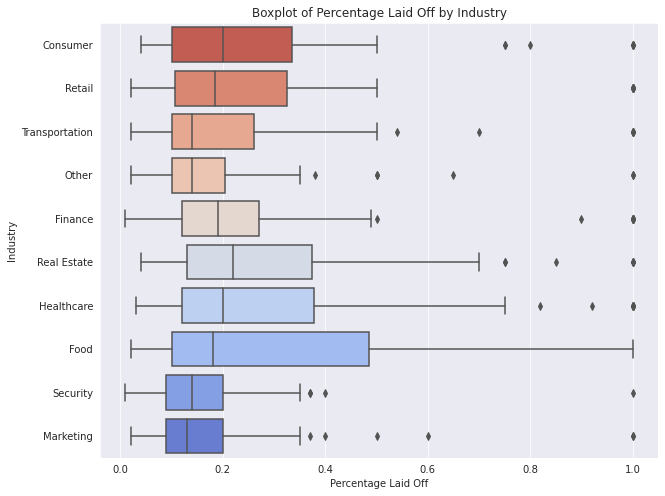

In [16]:
# boxplot of pct layoff
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x="percentage_laid_off", y="industry", data=df, order=inds, palette='coolwarm_r')
plt.title('Boxplot of Percentage Laid Off by Industry')
plt.xlabel('Percentage Laid Off')
plt.ylabel('Industry')
plt.show()

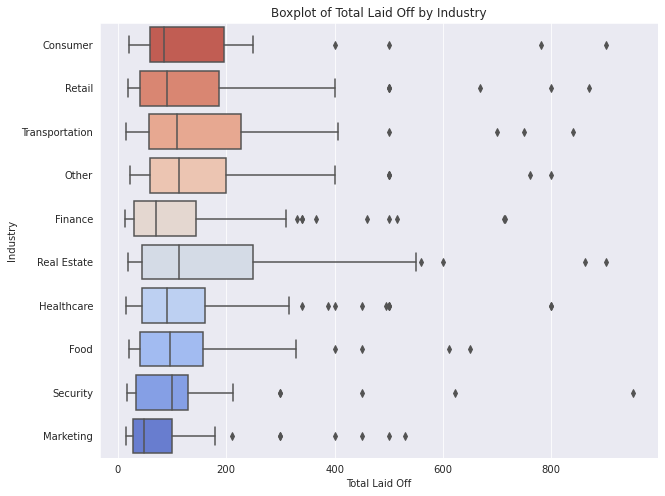

In [17]:
# boxplot of total layoff

# remove outliers (initial's range heavily shrinked with large outliers)
q_low = df["total_laid_off"].quantile(0.05)
q_hi  = df["total_laid_off"].quantile(0.95)
df_filtered = df[(df["total_laid_off"] < q_hi) & (df["total_laid_off"] > q_low)]

plt.figure(figsize=(10, 8))
ax = sns.boxplot(x="total_laid_off", y="industry", data=df_filtered, order=inds, palette='coolwarm_r')
plt.title('Boxplot of Total Laid Off by Industry')
plt.xlabel('Total Laid Off')
plt.ylabel('Industry')
plt.show()

### What is the financing status of companies with a high percentage of layoffs?

In [18]:
df["percentage_laid_off"].quantile(0.25), df["percentage_laid_off"].quantile(0.75)

(0.1, 0.29)

In [19]:
hRateCompn = df[df.percentage_laid_off >= 0.3]
hRateCompn.stage.value_counts()

Series B          59
Unknown           39
Series C          35
Series A          35
Post-IPO          28
Seed              19
Series D          18
Acquired          18
Series E          12
Series F           4
Private Equity     3
Series H           2
Series G           1
Name: stage, dtype: int64

### In which regions are the companies with high layoff ratios located?

In [20]:
hRateCompn.location.value_counts()[:10]

SF Bay Area      106
New York City     48
Boston            22
Los Angeles       22
Seattle           14
Austin             6
Chicago            4
Portland           4
Minneapolis        3
Columbus           3
Name: location, dtype: int64

### What are the future trends of the layoff wave?

### Has the wave of layoffs reached or passed its peak?